# 1. Introduction and Setup
In this notebook, we'll implement a deep learning model for heart sound classification. We'll use a custom neural network architecture based on ResNet50 to classify heart sounds into five categories: Normal (N), Aortic Stenosis (AS), Mitral Valve Prolapse (MVP), Mitral Regurgitation (MR), and Mitral Stenosis (MS).

The dataset used is the Yaseen Dataset which can be found in the following link:

https://github.com/yaseen21khan/Classification-of-Heart-Sound-Signal-Using-Multiple-Features-/tree/master

**1.1 Import Libraries**

We start by importing the necessary libraries for our project. These include libraries for data manipulation, audio processing, machine learning, and visualization.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from tqdm import tqdm
import random
from sklearn.preprocessing import label_binarize
from itertools import cycle
from collections import Counter
from sklearn.metrics import confusion_matrix

**1.2 Set up GPU/CPU Device**

We'll check if a GPU is available and set it as our device. If not, we'll use the CPU. This ensures our code can run efficiently on different hardware configurations.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**1.3 Define Constants**

Here, we define constants that will be used throughout our project. These include audio processing parameters and our classification categories.

In [4]:
SAMPLE_RATE = 22050
DURATION = 2
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
CLASSES = ['N', 'AS', 'MVP', 'MR', 'MS']

# 2. Data Preprocessing

Proper data preprocessing is crucial for the success of our model. In this section, we implement functions to load, preprocess, and augment our audio data.

**2.1 Audio Loading and Preprocessing**

This function loads an audio file, resamples it to our desired sample rate, and generates a mel spectrogram. Mel spectrograms are a popular representation for audio classification tasks.

In [5]:
def load_and_preprocess_audio(file_path):
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    if len(audio) < SAMPLE_RATE * DURATION:
        audio = np.pad(audio, (0, SAMPLE_RATE * DURATION - len(audio)))
    else:
        audio = audio[:SAMPLE_RATE * DURATION]
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

**2.2 Data Augmentation**

Data augmentation helps improve our model's generalization by creating variations of our training data. This function applies techniques like time stretching, pitch shifting, and adding noise to our audio samples.

In [6]:
def augment_audio(audio, sr=22050, augment_prob=0.5):
    # Time stretching
    if np.random.random() < augment_prob:
        stretch_factor = np.random.uniform(0.8, 1.2)
        audio = librosa.effects.time_stretch(audio, rate=stretch_factor)

    # Pitch shifting
    if np.random.random() < augment_prob:
        n_steps = np.random.randint(-4, 5)  # shift by -4 to 4 semitones
        audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

    # Adding Gaussian noise
    if np.random.random() < augment_prob:
        noise_factor = np.random.uniform(0.005, 0.02)
        noise = np.random.randn(len(audio))
        audio = audio + noise_factor * noise

    # Random gain
    if np.random.random() < augment_prob:
        gain_factor = np.random.uniform(0.8, 1.2)
        audio = audio * gain_factor

    # Randomly crop or pad to maintain 2-second duration
    target_length = 2 * sr
    if len(audio) > target_length:
        start = np.random.randint(0, len(audio) - target_length)
        audio = audio[start:start+target_length]
    elif len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')

    # Ensure the audio is in the valid range [-1, 1]
    audio = np.clip(audio, -1, 1)

    return audio

**2.3 Custom Dataset Class**

We create a custom PyTorch Dataset class to handle our heart sound data. This class will load audio files, apply preprocessing and augmentation, and return mel spectrograms with their corresponding labels.

In [7]:
class HeartSoundDataset(Dataset):
    def __init__(self, file_paths, labels, augment=False, fixed_length=87):
        self.file_paths = file_paths
        self.labels = labels
        self.augment = augment
        self.fixed_length = fixed_length

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        audio, sr = librosa.load(self.file_paths[idx], sr=SAMPLE_RATE, duration=DURATION)

        if self.augment:
            audio = augment_audio(audio, sr=sr)

        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Normalize the mel spectrogram
        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / mel_spec_db.std()

        # Pad or truncate the spectrogram to fixed_length
        if mel_spec_db.shape[1] < self.fixed_length:
            pad_width = self.fixed_length - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :self.fixed_length]

        label = self.labels[idx]
        return torch.FloatTensor(mel_spec_db).unsqueeze(0), torch.tensor(label)

**2.4 Custom Collate Function**

The collate function is used by PyTorch's DataLoader to batch the data. We create a custom function to ensure our variable-length spectrograms are properly batched.

In [8]:
def collate_fn(batch):
    specs, labels = zip(*batch)
    specs = torch.stack(specs)
    labels = torch.stack(labels)
    return specs, labels

# 3. Model Architecture

The model, SAINet, is based on ResNet50 with modifications for our specific task of heart sound classification.

The SAINet model is based on ResNet50 with the following modifications:

**1.Base Model:** Pre-trained ResNet50 - Leverages transfer learning from ImageNet dataset

**2.Input Layer:** Modified for mel spectrograms - Changed from 3 channels to 1 channel input

**3.Feature Extractor:** Uses all ResNet50 layers except the final fully connected layer

**4.Custom Classification Head:**

*   FC Layer 1: 2048 -> 64 units
*   ReLU activation Dropout (rate = 0.5)
*   FC Layer 2: 64 -> 5 units (output classes)



**5.Model Flow:**

Input (1, 128, T) -> Modified ResNet50 -> Flatten -> FC1 -> ReLU -> Dropout -> FC2 -> Output (5)

**3.1 SAINet Class**

This class defines our model architecture. We modify the input layer to accept our mel spectrograms and add custom fully connected layers for our classification task.

In [9]:
class SAINet(nn.Module):
    def __init__(self, num_classes):
        super(SAINet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the last fully connected layer
        modules = list(self.resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        self.fc1 = nn.Linear(2048, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 4. Training the Model

Here, we bring everything together to train our model. This includes initializing the model, setting up the optimizer and loss function, and running the training loop for a specified number of epochs.

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_acc = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_acc = correct / total
        val_accuracies.append(val_acc)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    return model, train_losses, val_losses, train_accuracies, val_accuracies

# 5. Evaluation and Visualization Functions

This sections contains functions that evaluate and allow us to visualise the data and model performance.

**5.1 Model Evaluation**

This function evaluates our trained model on the test set, calculating accuracy and generating predictions for further analysis.

In [11]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

**5.2 Visualization Functions**

These functions help us visualize various aspects of our data and model performance.

**5.2.1 Sample Spectrograms**

This function displays sample mel spectrograms from our dataset, helping us understand our input data.

In [12]:
def get_sample_files(file_paths, labels):
    label_dict = {label: [] for label in CLASSES}
    for file_path, label in zip(file_paths, labels):
        label_dict[CLASSES[label]].append(file_path)
    sample_file_paths = []
    sample_labels = []
    for label in CLASSES:
        if label_dict[label]:
            sample_file_path = random.choice(label_dict[label])
            sample_file_paths.append(sample_file_path)
            sample_labels.append(CLASSES.index(label))

    return sample_file_paths, sample_labels

def display_sample_spectrograms(file_paths, labels):
    sample_file_paths, sample_labels = get_sample_files(file_paths, labels)
    num_samples = len(CLASSES)

    plt.figure(figsize=(10, num_samples * 1.5))
    for i in range(num_samples):
        mel_spec_db = load_and_preprocess_audio(sample_file_paths[i])

        plt.subplot(num_samples, 1, i+1)
        plt.imshow(mel_spec_db, aspect='auto', origin='lower')
        plt.title(f'Label: {CLASSES[sample_labels[i]]}')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout(pad=1.0)

    plt.tight_layout()
    plt.show()

**5.2.2 Loss Curves**

We plot the training and validation loss curves to visualize how our model's performance changes during training.

In [13]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

**5.2.3 Accuracy Curves**

Similar to loss curves, we plot accuracy curves to see how our model's accuracy improves over time.

In [14]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

**5.2.4 Confusion Matrix**

A confusion matrix helps us understand which classes our model is confusing with each other.

In [15]:
def plot_confusion_matrix(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

**5.2.5 ROC Curves**

ROC curves provide insight into our model's performance across different classification thresholds.

In [16]:
def plot_roc_curve(all_labels, all_preds):
    y_test_bin = label_binarize(all_labels, classes=list(range(len(CLASSES))))
    y_pred_bin = label_binarize(all_preds, classes=list(range(len(CLASSES))))
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(len(CLASSES)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'darkgreen'])
    for i, color in zip(range(len(CLASSES)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {CLASSES[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

# 6. Main Execution
This section brings all the components together to train and evaluate our model.

**6.1 Data Loading and Preprocessing**

We load our dataset, preprocess the audio files, and split the data into training, validation, and test sets.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


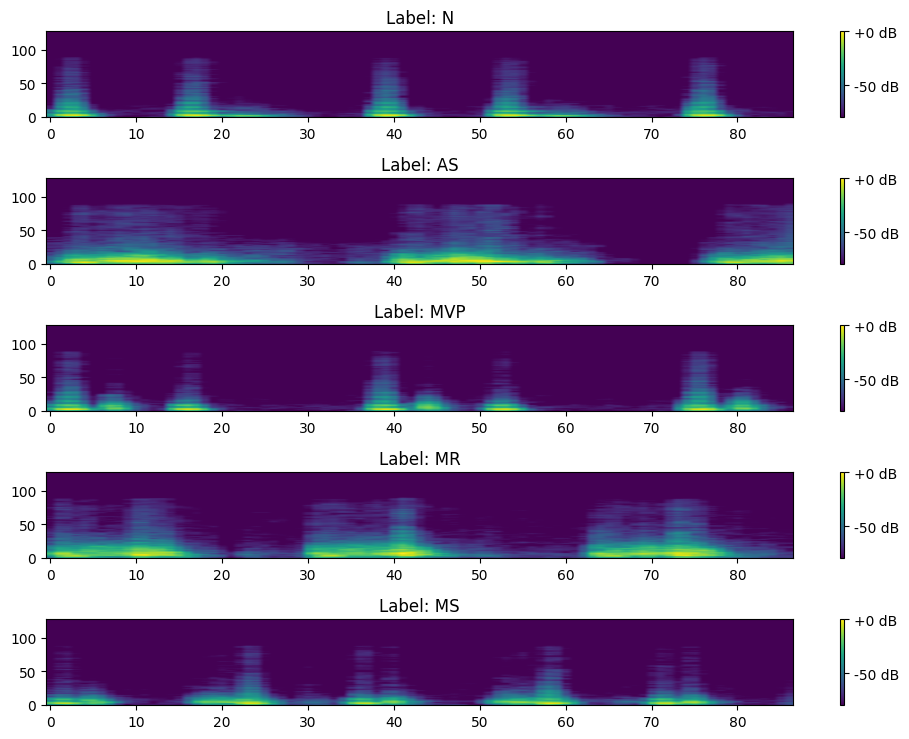

In [17]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/heart_sounds'
file_paths = []
labels = []
for file in os.listdir(data_dir):
    if file.endswith('.wav'):
        file_paths.append(os.path.join(data_dir, file))
        label = file.split('_')[1]
        labels.append(CLASSES.index(label))

# Get sample files
sample_file_paths, sample_labels = get_sample_files(file_paths, labels)

# Display sample spectrograms
display_sample_spectrograms(sample_file_paths, sample_labels)

**6.2 Model Initialization**

Here, we initialize our SAINet model, define the loss function, and set up the optimizer.


In [18]:
# Split data
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = HeartSoundDataset(train_files, train_labels, augment=True)
val_dataset = HeartSoundDataset(val_files, val_labels, augment=False)
test_dataset = HeartSoundDataset(test_files, test_labels, augment=False)

train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=24)
test_loader = DataLoader(test_dataset, batch_size=24)

# Initialize model, loss, and optimizer
model = SAINet(num_classes=len(CLASSES)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


**6.3 Model Training**

We execute the main training loop, training our model for the specified number of epochs.

In [19]:
num_epochs = 95
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

100%|██████████| 27/27 [00:48<00:00,  1.81s/it]


Epoch 1/95, Loss: 1.3734, Val Loss: 1.1472, Acc: 0.4813, Val Acc: 0.6398


100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Epoch 2/95, Loss: 0.7642, Val Loss: 0.3335, Acc: 0.7516, Val Acc: 0.9006


100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 3/95, Loss: 0.5296, Val Loss: 0.1474, Acc: 0.8516, Val Acc: 0.9503


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 4/95, Loss: 0.3844, Val Loss: 0.0881, Acc: 0.8984, Val Acc: 0.9938


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 5/95, Loss: 0.3447, Val Loss: 0.4404, Acc: 0.9125, Val Acc: 0.8571


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch 6/95, Loss: 0.3705, Val Loss: 0.0633, Acc: 0.8938, Val Acc: 0.9752


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch 7/95, Loss: 0.2953, Val Loss: 0.0808, Acc: 0.9313, Val Acc: 0.9752


100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 8/95, Loss: 0.2764, Val Loss: 0.0374, Acc: 0.9406, Val Acc: 1.0000


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch 9/95, Loss: 0.1734, Val Loss: 0.0260, Acc: 0.9578, Val Acc: 0.9876


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch 10/95, Loss: 0.1605, Val Loss: 0.0226, Acc: 0.9578, Val Acc: 0.9938


100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 11/95, Loss: 0.1671, Val Loss: 0.0591, Acc: 0.9641, Val Acc: 0.9752


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 12/95, Loss: 0.1845, Val Loss: 0.0150, Acc: 0.9484, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.00s/it]


Epoch 13/95, Loss: 0.1057, Val Loss: 0.0291, Acc: 0.9750, Val Acc: 0.9938


100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 14/95, Loss: 0.1625, Val Loss: 0.1477, Acc: 0.9531, Val Acc: 0.9565


100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 15/95, Loss: 0.1764, Val Loss: 0.0686, Acc: 0.9469, Val Acc: 0.9752


100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


Epoch 16/95, Loss: 0.1913, Val Loss: 0.0078, Acc: 0.9500, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 17/95, Loss: 0.1607, Val Loss: 0.0246, Acc: 0.9625, Val Acc: 0.9876


100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


Epoch 18/95, Loss: 0.0953, Val Loss: 0.0055, Acc: 0.9766, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 19/95, Loss: 0.1275, Val Loss: 0.0043, Acc: 0.9719, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 20/95, Loss: 0.1312, Val Loss: 0.0344, Acc: 0.9641, Val Acc: 0.9938


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 21/95, Loss: 0.1500, Val Loss: 0.0242, Acc: 0.9594, Val Acc: 0.9876


100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 22/95, Loss: 0.0813, Val Loss: 0.0129, Acc: 0.9719, Val Acc: 0.9938


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 23/95, Loss: 0.0869, Val Loss: 0.0051, Acc: 0.9844, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 24/95, Loss: 0.1264, Val Loss: 0.0135, Acc: 0.9719, Val Acc: 0.9938


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch 25/95, Loss: 0.0881, Val Loss: 0.0275, Acc: 0.9719, Val Acc: 0.9938


100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


Epoch 26/95, Loss: 0.0632, Val Loss: 0.0015, Acc: 0.9812, Val Acc: 1.0000


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


Epoch 27/95, Loss: 0.0625, Val Loss: 0.0028, Acc: 0.9859, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


Epoch 28/95, Loss: 0.0648, Val Loss: 0.0004, Acc: 0.9844, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 29/95, Loss: 0.0948, Val Loss: 0.0610, Acc: 0.9781, Val Acc: 0.9876


100%|██████████| 27/27 [00:27<00:00,  1.04s/it]


Epoch 30/95, Loss: 0.0837, Val Loss: 0.0618, Acc: 0.9766, Val Acc: 0.9752


100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 31/95, Loss: 0.1614, Val Loss: 0.0207, Acc: 0.9500, Val Acc: 0.9938


100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 32/95, Loss: 0.1061, Val Loss: 0.0030, Acc: 0.9766, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 33/95, Loss: 0.0582, Val Loss: 0.0027, Acc: 0.9844, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


Epoch 34/95, Loss: 0.0675, Val Loss: 0.0009, Acc: 0.9828, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 35/95, Loss: 0.0902, Val Loss: 0.0301, Acc: 0.9797, Val Acc: 0.9876


100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 36/95, Loss: 0.0469, Val Loss: 0.0007, Acc: 0.9922, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 37/95, Loss: 0.1251, Val Loss: 0.0073, Acc: 0.9719, Val Acc: 0.9938


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 38/95, Loss: 0.0982, Val Loss: 0.0027, Acc: 0.9688, Val Acc: 1.0000


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch 39/95, Loss: 0.1093, Val Loss: 0.0018, Acc: 0.9719, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 40/95, Loss: 0.0909, Val Loss: 0.0031, Acc: 0.9828, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 41/95, Loss: 0.0769, Val Loss: 0.0016, Acc: 0.9797, Val Acc: 1.0000


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch 42/95, Loss: 0.0531, Val Loss: 0.0057, Acc: 0.9875, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 43/95, Loss: 0.0267, Val Loss: 0.0008, Acc: 0.9953, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


Epoch 44/95, Loss: 0.0577, Val Loss: 0.0005, Acc: 0.9891, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 45/95, Loss: 0.0640, Val Loss: 0.0012, Acc: 0.9812, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


Epoch 46/95, Loss: 0.0432, Val Loss: 0.0011, Acc: 0.9891, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 47/95, Loss: 0.0775, Val Loss: 0.0078, Acc: 0.9812, Val Acc: 0.9938


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 48/95, Loss: 0.0394, Val Loss: 0.0028, Acc: 0.9875, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 49/95, Loss: 0.0524, Val Loss: 0.0027, Acc: 0.9859, Val Acc: 1.0000


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch 50/95, Loss: 0.0774, Val Loss: 0.0003, Acc: 0.9781, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.04s/it]


Epoch 51/95, Loss: 0.0646, Val Loss: 0.0036, Acc: 0.9828, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 52/95, Loss: 0.0715, Val Loss: 0.0037, Acc: 0.9828, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


Epoch 53/95, Loss: 0.0623, Val Loss: 0.0244, Acc: 0.9859, Val Acc: 0.9876


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 54/95, Loss: 0.0432, Val Loss: 0.0016, Acc: 0.9859, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 55/95, Loss: 0.0273, Val Loss: 0.0017, Acc: 0.9938, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 56/95, Loss: 0.0656, Val Loss: 0.0334, Acc: 0.9844, Val Acc: 0.9814


100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 57/95, Loss: 0.0607, Val Loss: 0.0010, Acc: 0.9859, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


Epoch 58/95, Loss: 0.0442, Val Loss: 0.0007, Acc: 0.9875, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 59/95, Loss: 0.0625, Val Loss: 0.0338, Acc: 0.9906, Val Acc: 0.9876


100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 60/95, Loss: 0.0735, Val Loss: 0.0009, Acc: 0.9766, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 61/95, Loss: 0.0477, Val Loss: 0.0052, Acc: 0.9859, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 62/95, Loss: 0.0455, Val Loss: 0.0005, Acc: 0.9875, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 63/95, Loss: 0.0417, Val Loss: 0.0019, Acc: 0.9891, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


Epoch 64/95, Loss: 0.0465, Val Loss: 0.0118, Acc: 0.9891, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 65/95, Loss: 0.0831, Val Loss: 0.0157, Acc: 0.9844, Val Acc: 0.9938


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


Epoch 66/95, Loss: 0.0753, Val Loss: 0.0240, Acc: 0.9812, Val Acc: 0.9938


100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


Epoch 67/95, Loss: 0.0218, Val Loss: 0.0015, Acc: 0.9969, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 68/95, Loss: 0.0155, Val Loss: 0.0004, Acc: 0.9969, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.00s/it]


Epoch 69/95, Loss: 0.0815, Val Loss: 0.0003, Acc: 0.9859, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 70/95, Loss: 0.0476, Val Loss: 0.0006, Acc: 0.9859, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 71/95, Loss: 0.0852, Val Loss: 0.0260, Acc: 0.9797, Val Acc: 0.9876


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 72/95, Loss: 0.0961, Val Loss: 0.0200, Acc: 0.9781, Val Acc: 0.9938


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 73/95, Loss: 0.0449, Val Loss: 0.0008, Acc: 0.9891, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 74/95, Loss: 0.0422, Val Loss: 0.0002, Acc: 0.9891, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 75/95, Loss: 0.0401, Val Loss: 0.0054, Acc: 0.9875, Val Acc: 0.9938


100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 76/95, Loss: 0.0845, Val Loss: 0.0169, Acc: 0.9750, Val Acc: 0.9876


100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 77/95, Loss: 0.0407, Val Loss: 0.0088, Acc: 0.9922, Val Acc: 0.9938


100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 78/95, Loss: 0.0315, Val Loss: 0.0033, Acc: 0.9922, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 79/95, Loss: 0.0340, Val Loss: 0.0003, Acc: 0.9906, Val Acc: 1.0000


100%|██████████| 27/27 [00:26<00:00,  1.04it/s]


Epoch 80/95, Loss: 0.0809, Val Loss: 0.0110, Acc: 0.9875, Val Acc: 0.9938


100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


Epoch 81/95, Loss: 0.0256, Val Loss: 0.0004, Acc: 0.9938, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


Epoch 82/95, Loss: 0.0259, Val Loss: 0.0015, Acc: 0.9906, Val Acc: 1.0000


100%|██████████| 27/27 [00:29<00:00,  1.11s/it]


Epoch 83/95, Loss: 0.0360, Val Loss: 0.0009, Acc: 0.9922, Val Acc: 1.0000


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch 84/95, Loss: 0.0409, Val Loss: 0.0007, Acc: 0.9922, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


Epoch 85/95, Loss: 0.0683, Val Loss: 0.0065, Acc: 0.9844, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 86/95, Loss: 0.0658, Val Loss: 0.0003, Acc: 0.9797, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 87/95, Loss: 0.0396, Val Loss: 0.0010, Acc: 0.9938, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 88/95, Loss: 0.0280, Val Loss: 0.0003, Acc: 0.9938, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


Epoch 89/95, Loss: 0.0178, Val Loss: 0.0006, Acc: 0.9938, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.00s/it]


Epoch 90/95, Loss: 0.0193, Val Loss: 0.0001, Acc: 0.9938, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 91/95, Loss: 0.0273, Val Loss: 0.0014, Acc: 0.9938, Val Acc: 1.0000


100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 92/95, Loss: 0.0112, Val Loss: 0.0029, Acc: 0.9953, Val Acc: 1.0000


100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 93/95, Loss: 0.0155, Val Loss: 0.0002, Acc: 0.9984, Val Acc: 1.0000


100%|██████████| 27/27 [00:26<00:00,  1.00it/s]


Epoch 94/95, Loss: 0.0218, Val Loss: 0.0001, Acc: 0.9938, Val Acc: 1.0000


100%|██████████| 27/27 [00:26<00:00,  1.00it/s]


Epoch 95/95, Loss: 0.0184, Val Loss: 0.0128, Acc: 0.9953, Val Acc: 0.9938


**6.4 Model Evaluation**

After training, we evaluate our model on the test set to get final performance metrics.

In [20]:
all_preds, all_labels = evaluate_model(model, test_loader)

**6.5 Generate Visualizations**

Finally, we generate and display all our visualizations to help interpret our model's performance.

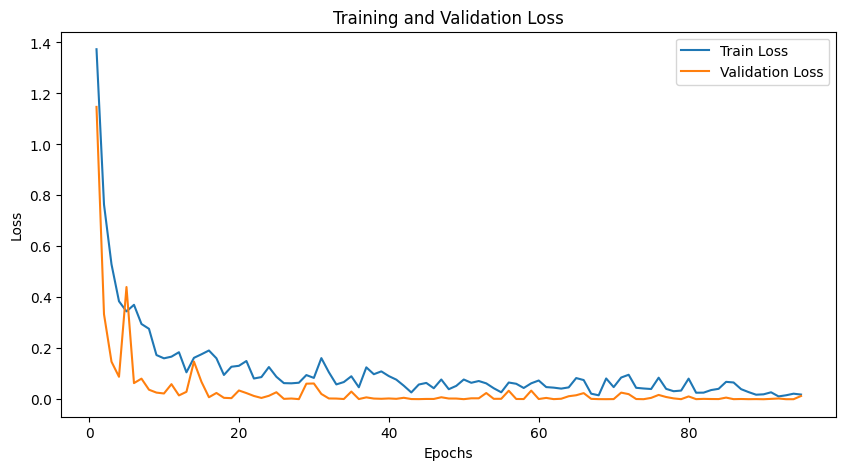

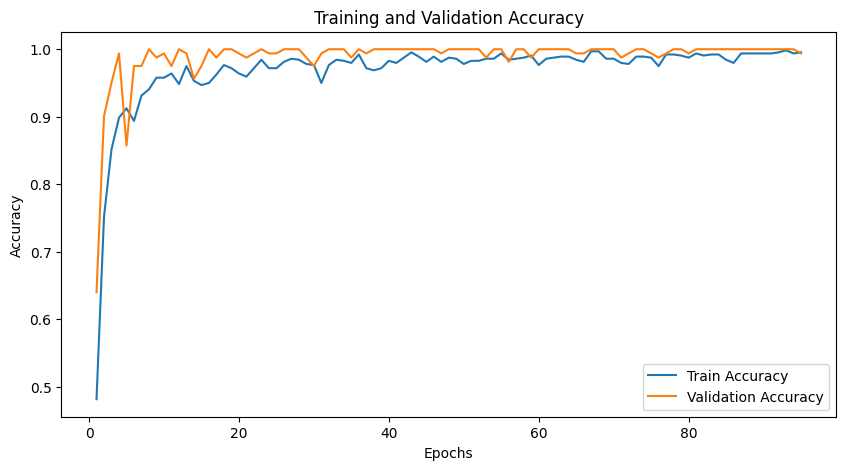

In [21]:
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

# 7. Results and Analysis
In this section, we analyze the performance of our trained model.

**7.1 Final Accuracy**

We display and discuss the final accuracy of our model on the test set.

In [22]:
cm = confusion_matrix(all_labels, all_preds)

accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f'Final Accuracy: {accuracy:.4f}')

Final Accuracy: 0.9950


**7.2 Confusion Matrix Analysis**

We analyze the confusion matrix to understand which heart sound classes are most challenging for our model.

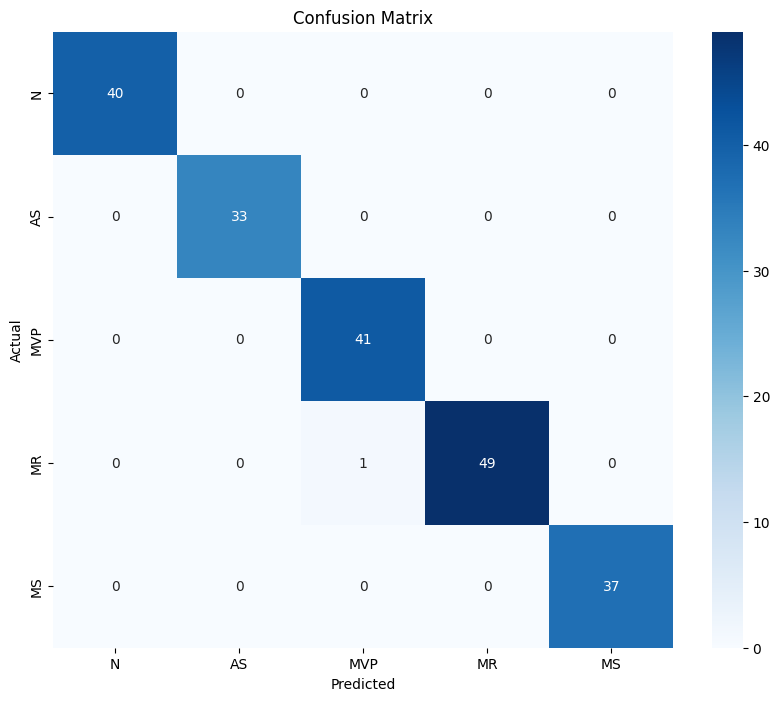

In [23]:
plot_confusion_matrix(all_labels, all_preds)

**7.3 ROC Curve Interpretation**

We interpret the ROC curves to understand our model's performance across different classification thresholds.

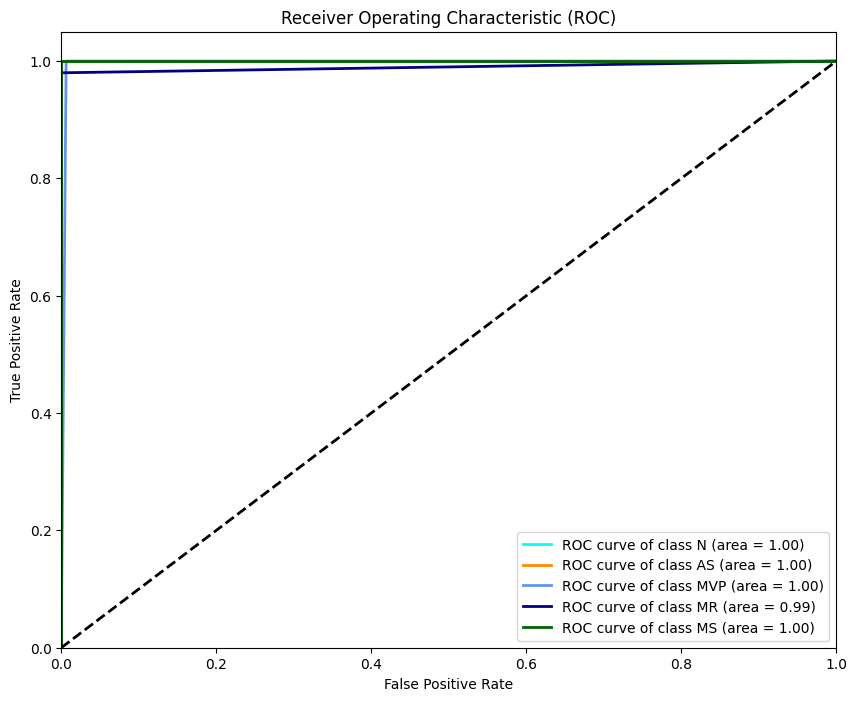

In [24]:
plot_roc_curve(all_labels, all_preds)